## Project Scope ##

The goal of this master's project is to create a system that is part of some bigger medical system like a chatbot and it can read the input of potential patients in natural language, and then recognize the medical intent and symptoms. Since BERT is only an encoder model, we can't expect it to generate the extensive result. If there's a need to extend this chatbot we can use some open-source AI model like LLAMA-3 or Mistral AI.

First, let's load the libraries we need as well as load the data we'll use.

In [158]:
pip install torch torchvision torchaudio transformers pandas numpy matplotlib scikit-learn matplotlib jupyter



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [159]:
import torch
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

PyTorch version: 2.8.0
MPS available: True
MPS built: True


In [162]:
!python -m pip install --upgrade pip setuptools wheel
!python -m pip install seaborn


In [163]:
!pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [165]:
data = pd.read_csv('data.csv')
data1 = data[['phrase','prompt']]
data1.sample(5)

,phrase,prompt
39,i feel pain in my knee,Knee pain
2075,My ear hurts and it's worse when I swallow. M...,Ear ache
2608,When I play football I have muscle pain.,Muscle pain
769,My grandmother last year went to hospital beca...,Hard to breath
3543,I break out on my face very frequently,Acne


In [168]:
df=data1.copy()
df.isna().sum()

phrase    0
prompt    0
dtype: int64

In [170]:
df['prompt'].value_counts()

prompt
Acne                  328
Shoulder pain         320
Joint pain            318
Infected wound        306
Knee pain             305
Cough                 293
Feeling dizzy         283
Muscle pain           282
Heart hurts           273
Ear ache              270
Hair falling out      264
Head ache             263
Feeling cold          263
Skin issue            262
Stomach ache          261
Back pain             259
Neck pain             251
Internal pain         248
Blurry vision         246
Body feels weak       241
Hard to breath        233
Emotional pain        231
Injury from sports    230
Foot ache             223
Open wound            208
Name: count, dtype: int64

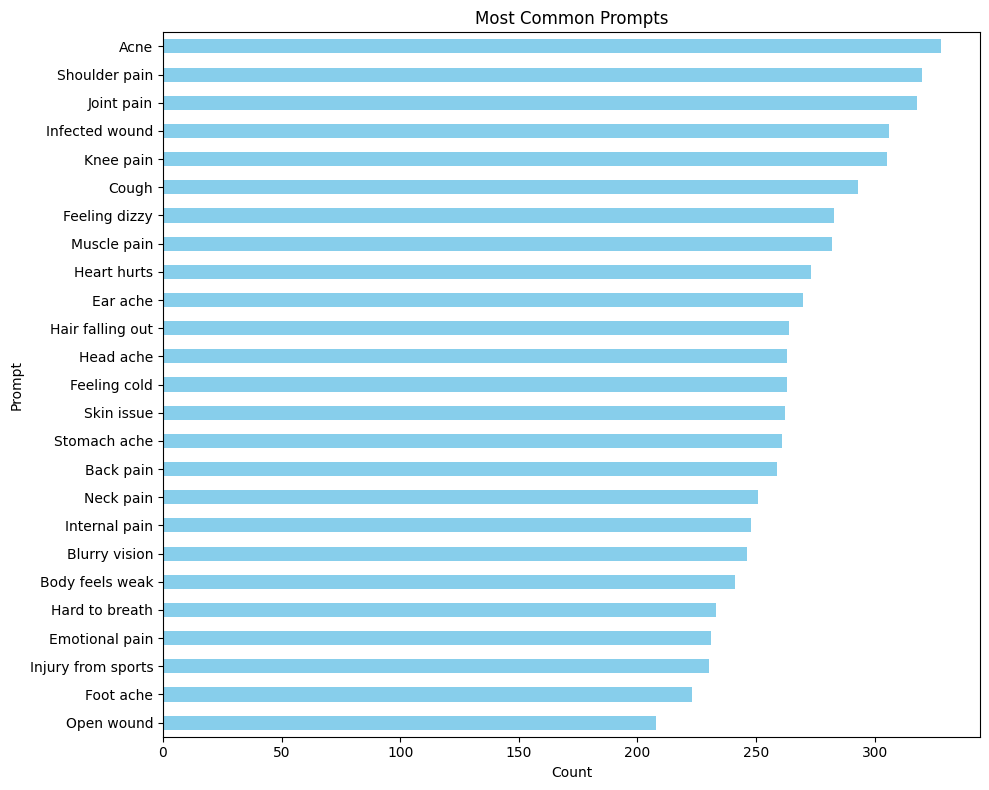

In [172]:
import matplotlib.pyplot as plt

top_counts = df['prompt'].value_counts().head(30)

plt.figure(figsize=(10, 8))
top_counts.sort_values().plot(kind='barh', color='skyblue')

plt.title('Most Common Prompts')
plt.xlabel('Count')
plt.ylabel('Prompt')
plt.tight_layout()
plt.show()

In [174]:
print('Total number of intents: %d' % len(df['prompt'].value_counts().index))
print('Total number of intents: %d' % len(df['prompt'].value_counts().index))


Total number of intents: 25
Total number of intents: 25


## 3. Split data to train, validation and test sets for balance

It's the best to split data to train(70%), validation(10%) and testset (20%) stratified by the variable "intent". After stratification, data for each intent will balanced and data for each set will be proportional to 70%, 10% and 20%. That is crucial for training and testing purposes.

In [177]:
from sklearn.model_selection import train_test_split

# Normalize text for grouping by phrase.
df_clean = df[['phrase', 'prompt']].copy()
df_clean['phrase_norm'] = df_clean['phrase'].astype(str).str.strip().str.lower().str.split().str.join(' ')

# Unique phrase-label mapping for group-based split.
# (If a phrase maps to multiple intents, drop it to avoid contradictory supervision.)
df_unique_pairs = df_clean.drop_duplicates(subset=['phrase_norm', 'prompt']).copy()
intent_counts = df_unique_pairs.groupby('phrase_norm')['prompt'].nunique()
ambiguous_phrases = set(intent_counts[intent_counts > 1].index)

phrase_label_df = df_unique_pairs[~df_unique_pairs['phrase_norm'].isin(ambiguous_phrases)].drop_duplicates(subset=['phrase_norm'])[['phrase_norm', 'prompt']].copy()

print(f"Original rows: {len(df)}")
print(f"Unique (phrase,intent) pairs: {len(df_unique_pairs)}")
print(f"Ambiguous phrases removed: {len(ambiguous_phrases)}")
print(f"Unique phrases used for split: {len(phrase_label_df)}")

# Split on unique phrases only.
X_pool, phrase_unit, y_pool, intent_unit_phrase = train_test_split(
    phrase_label_df['phrase_norm'],
    phrase_label_df['prompt'],
    stratify=phrase_label_df['prompt'],
    test_size=0.10,
    random_state=4612,
)

X_train_val, phrase_test, y_train_val, intent_test_phrase = train_test_split(
    X_pool,
    y_pool,
    stratify=y_pool,
    test_size=0.20,
    random_state=4612,
)

phrase_train, phrase_val, intent_train_phrase, intent_val_phrase = train_test_split(
    X_train_val,
    y_train_val,
    stratify=y_train_val,
    test_size=0.125,
    random_state=4612,
)

# Expand back to ALL rows (all recordings) for each phrase split.
eligible_rows = df_clean[df_clean['phrase_norm'].isin(set(phrase_label_df['phrase_norm']))].copy()

train_df = eligible_rows[eligible_rows['phrase_norm'].isin(set(phrase_train))].copy()
val_df = eligible_rows[eligible_rows['phrase_norm'].isin(set(phrase_val))].copy()
test_df = eligible_rows[eligible_rows['phrase_norm'].isin(set(phrase_test))].copy()
unit_df = eligible_rows[eligible_rows['phrase_norm'].isin(set(phrase_unit))].copy()

sentence_train, intent_train = train_df['phrase_norm'], train_df['prompt']
sentence_val, intent_val = val_df['phrase_norm'], val_df['prompt']
sentence_test, intent_test = test_df['phrase_norm'], test_df['prompt']
sentence_unit, intent_unit = unit_df['phrase_norm'], unit_df['prompt']


Original rows: 6661
Unique (phrase,intent) pairs: 705
Ambiguous phrases removed: 2
Unique phrases used for split: 701


In [179]:
print(
    f"Rows -> train: {len(sentence_train)} | val: {len(sentence_val)} | test: {len(sentence_test)} | unseen_unit: {len(sentence_unit)}\n"
    f"Unique phrases -> train: {phrase_train.nunique()} | val: {phrase_val.nunique()} | test: {phrase_test.nunique()} | unseen_unit: {phrase_unit.nunique()}"
)


Rows -> train: 4203 | val: 601 | test: 1165 | unseen_unit: 672
Unique phrases -> train: 441 | val: 63 | test: 126 | unseen_unit: 71


## 4. Tokenization and input formatting

Let's prep the input data to the correct format before training as follows:

* tokenizing all sentences 
* padding and truncating all sentences to the same length. 
* Creating the attention masks which explicitly differentiate real tokens from [PAD] tokens. 0 or 1.
* encoding the label "intent" to numbers. 25 intents to 25 numbers.
* creating DataLoaders for our training, validation and test sets

In [182]:
pip install --upgrade "ipywidgets==8.*" "jupyterlab-widgets==3.*" "widgetsnbextension==4.*"



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [183]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [184]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE =32
VALID_BATCH_SIZE = 64
EPSILON = 1e-08
EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 1215
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [187]:
max_len = 0
input = []
length=[]
# For every sentence...
for sent in sentence_train:

    # Tokenize the text and add special tokens--`[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input.append(input_ids)
    length.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    mean_len = sum(length)/len(length)
#39 tokens is the maximum number of tokens in a sentence (transcription). Also, a sentence has 14 tokens on average.
print('Max sentence length:%d \nMean sentence length:%d' % (max_len,mean_len))

Max sentence length:39 
Mean sentence length:13


In [188]:
# create a function to tokenize sentences.  
def tokenize(sentence):
  batch = tokenizer(list(sentence),             
                  #Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
                  padding=True, 
                  truncation=True,
                  return_tensors="pt")
  return batch

In [190]:
tok_train = tokenize(sentence_train)
tok_val = tokenize(sentence_val)
tok_test = tokenize(sentence_test)
tok_unit = tokenize(sentence_unit)


In [193]:
from sklearn.preprocessing import LabelEncoder
# Fit label encoder ONLY on train set, then transform val/test/unseen holdout.
LE = LabelEncoder()
label_train = torch.tensor(LE.fit_transform(intent_train), dtype=torch.long)
label_val = torch.tensor(LE.transform(intent_val), dtype=torch.long)
label_test = torch.tensor(LE.transform(intent_test), dtype=torch.long)
label_unit = torch.tensor(LE.transform(intent_unit), dtype=torch.long)


In [196]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(tok_train['input_ids'], tok_train['attention_mask'], label_train)
validation_dataset = TensorDataset(tok_val['input_ids'], tok_val['attention_mask'], label_val)
test_dataset = TensorDataset(tok_test['input_ids'], tok_test['attention_mask'], label_test)
unit_dataset = TensorDataset(tok_unit['input_ids'], tok_unit['attention_mask'], label_unit)


In [198]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=TRAIN_BATCH_SIZE,
)

validation_dataloader = DataLoader(
    validation_dataset,
    sampler=SequentialSampler(validation_dataset),
    batch_size=VALID_BATCH_SIZE,
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=VALID_BATCH_SIZE,
)

unit_dataloader = DataLoader(
    unit_dataset,
    sampler=SequentialSampler(unit_dataset),
    batch_size=VALID_BATCH_SIZE,
)


## 5. Train BERT classification model

I use BertForSequenceClassification, a BERT model with an added single linear layer on top for classification. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.



In [201]:
import sys, subprocess
print("PYTHON:", sys.executable)
subprocess.run([sys.executable, "-m", "pip", "show", "tensorflow"])
subprocess.run([sys.executable, "-m", "pip", "show", "tensorflow-macos"])
subprocess.run([sys.executable, "-m", "pip", "show", "protobuf"])

PYTHON: /Users/danicasimic/torch_env/bin/python


Name: protobuf
Version: 4.25.3
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: /Users/danicasimic/torch_env/lib/python3.12/site-packages
Requires: 
Required-by: googleapis-common-protos, tensorboard


CompletedProcess(args=['/Users/danicasimic/torch_env/bin/python', '-m', 'pip', 'show', 'protobuf'], returncode=0)

In [203]:
from transformers import BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(LE.classes_)
)
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON
)

total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("Model on:", next(model.parameters()).device)


Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on: mps:0


In [204]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [205]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))   
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [209]:
%pip install tensorboard

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [211]:
import time
import random
import numpy as np
import torch

# ✅ Za konzistentnost
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ✅ Device za Apple Silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training on:", device)

def calculate_accu(preds, labels):
    return (preds == labels).sum().item()

def format_time(elapsed):
    return time.strftime("%H:%M:%S", time.gmtime(elapsed))

def train(epochs):
    total_t0 = time.time()

    for epoch in range(epochs):
        print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
        print("Training...")

        t0 = time.time()
        model.train()

        total_tr_loss = 0
        total_correct = 0
        total_examples = 0

        # ✅ Za svaki batch
        for step, batch in enumerate(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Reset gradijenata
            optimizer.zero_grad()

            # Forward
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_tr_loss += loss.item()

            # Accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += calculate_accu(preds, labels)
            total_examples += labels.size(0)

            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Periodični prikaz
            if step % 20 == 19:
                avg_loss = total_tr_loss / (step + 1)
                avg_acc = total_correct / total_examples
                print(f"  Step {step+1}/{len(train_dataloader)} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")

        # ✅ Kraj epohe
        epoch_loss = total_tr_loss / len(train_dataloader)
        epoch_acc = total_correct / total_examples
        epoch_time = format_time(time.time() - t0)

        print(f"\nEpoch {epoch+1} finished")
        print(f"  Average loss: {epoch_loss:.4f}")
        print(f"  Average accuracy: {epoch_acc:.4f}")
        print(f"  Epoch training time: {epoch_time}")

    total_training_time = format_time(time.time() - total_t0)
    print("\nTraining complete!")
    print("Total training time:", total_training_time)


Training on: mps


In [213]:
train(EPOCHS)



======== Epoch 1 / 4 ========
Training...
  Step 20/132 | Loss: 3.2366 | Acc: 0.0406
  Step 40/132 | Loss: 3.1758 | Acc: 0.0664
  Step 60/132 | Loss: 3.0958 | Acc: 0.1005
  Step 80/132 | Loss: 2.9971 | Acc: 0.1734
  Step 100/132 | Loss: 2.8770 | Acc: 0.2566
  Step 120/132 | Loss: 2.7498 | Acc: 0.3297

Epoch 1 finished
  Average loss: 2.6688
  Average accuracy: 0.3693
  Epoch training time: 00:00:39

======== Epoch 2 / 4 ========
Training...
  Step 20/132 | Loss: 1.6341 | Acc: 0.8828
  Step 40/132 | Loss: 1.5368 | Acc: 0.8844
  Step 60/132 | Loss: 1.4251 | Acc: 0.9078
  Step 80/132 | Loss: 1.3309 | Acc: 0.9215
  Step 100/132 | Loss: 1.2485 | Acc: 0.9284
  Step 120/132 | Loss: 1.1692 | Acc: 0.9357

Epoch 2 finished
  Average loss: 1.1250
  Average accuracy: 0.9398
  Epoch training time: 00:00:39

======== Epoch 3 / 4 ========
Training...
  Step 20/132 | Loss: 0.5886 | Acc: 0.9859
  Step 40/132 | Loss: 0.5527 | Acc: 0.9875
  Step 60/132 | Loss: 0.5226 | Acc: 0.9859
  Step 80/132 | Loss: 

In [214]:
from sklearn.metrics import classification_report
import numpy as np

def evaluate_split(model, data_loader, split_name="split"):
    model.eval()
    eval_loss = 0
    n_correct = 0
    n_examples = 0
    all_preds = []
    all_targets = []

    loss_function = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            ids = data[0].to(device, dtype=torch.long)
            mask = data[1].to(device, dtype=torch.long)
            targets = data[2].to(device, dtype=torch.long)

            outputs = model(ids, mask)
            logits = outputs[0]

            loss = loss_function(logits, targets)
            eval_loss += loss.item()

            _, pred_idx = torch.max(logits, dim=1)
            n_correct += calcuate_accu(pred_idx, targets)
            n_examples += targets.size(0)

            all_preds.extend(pred_idx.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())

    avg_loss = eval_loss / len(data_loader)
    accuracy = (n_correct * 100) / n_examples

    print(f"\n[{split_name}] Loss: {avg_loss:.4f}")
    print(f"[{split_name}] Accuracy: {accuracy:.2f}%")
    print(f"[{split_name}] Classification report:")
    print(classification_report(
        np.array(all_targets),
        np.array(all_preds),
        target_names=LE.classes_,
        digits=4,
        zero_division=0,
    ))


In [215]:
evaluate_split(model, validation_dataloader, split_name="Validation")
evaluate_split(model, test_dataloader, split_name="Test")
evaluate_split(model, unit_dataloader, split_name="Unseen Unit Holdout")



[Validation] Loss: 0.8872
[Validation] Accuracy: 76.71%
[Validation] Classification report:
                    precision    recall  f1-score   support

              Acne     1.0000    0.6562    0.7925        32
         Back pain     0.6774    1.0000    0.8077        21
     Blurry vision     1.0000    1.0000    1.0000        18
   Body feels weak     1.0000    0.4762    0.6452        21
             Cough     0.5510    1.0000    0.7105        27
          Ear ache     1.0000    1.0000    1.0000        28
    Emotional pain     0.9500    1.0000    0.9744        19
      Feeling cold     1.0000    1.0000    1.0000        26
     Feeling dizzy     0.7317    1.0000    0.8451        30
         Foot ache     1.0000    1.0000    1.0000        17
  Hair falling out     1.0000    1.0000    1.0000        18
    Hard to breath     1.0000    0.3125    0.4762        32
         Head ache     1.0000    0.5000    0.6667        16
       Heart hurts     1.0000    0.5500    0.7097        20
    In

In [223]:
train_texts = set(sentence_train)
val_texts = set(sentence_val)
test_texts = set(sentence_test)
unit_texts = set(sentence_unit)

print(f"Overlap train-val: {len(train_texts.intersection(val_texts))}")
print(f"Overlap train-test: {len(train_texts.intersection(test_texts))}")
print(f"Overlap train-unit: {len(train_texts.intersection(unit_texts))}")
print(f"Overlap val-test: {len(val_texts.intersection(test_texts))}")
print(f"Overlap val-unit: {len(val_texts.intersection(unit_texts))}")
print(f"Overlap test-unit: {len(test_texts.intersection(unit_texts))}")


Overlap train-val: 0
Overlap train-test: 0
Overlap train-unit: 0
Overlap val-test: 0
Overlap val-unit: 0
Overlap test-unit: 0


## 8. Advanced Evaluation and Insights

This section adds deeper diagnostics on the **unseen unit holdout**: confusion matrices, ROC curves, strongest confusions, class-level F1/support, and confidence behavior.


In [226]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    f1_score,
)
from sklearn.preprocessing import label_binarize


def collect_predictions(model, data_loader):
    model.eval()
    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            ids = batch[0].to(device, dtype=torch.long)
            mask = batch[1].to(device, dtype=torch.long)
            targets = batch[2].to(device, dtype=torch.long)

            outputs = model(ids, mask)
            logits = outputs[0]
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_targets.extend(targets.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    return np.array(all_targets), np.array(all_preds), np.array(all_probs)


y_true_u, y_pred_u, y_prob_u = collect_predictions(model, unit_dataloader)
label_names = LE.classes_

print(f"Unseen unit samples: {len(y_true_u)}")
print(f"Num classes: {len(label_names)}")


Unseen unit samples: 672
Num classes: 25


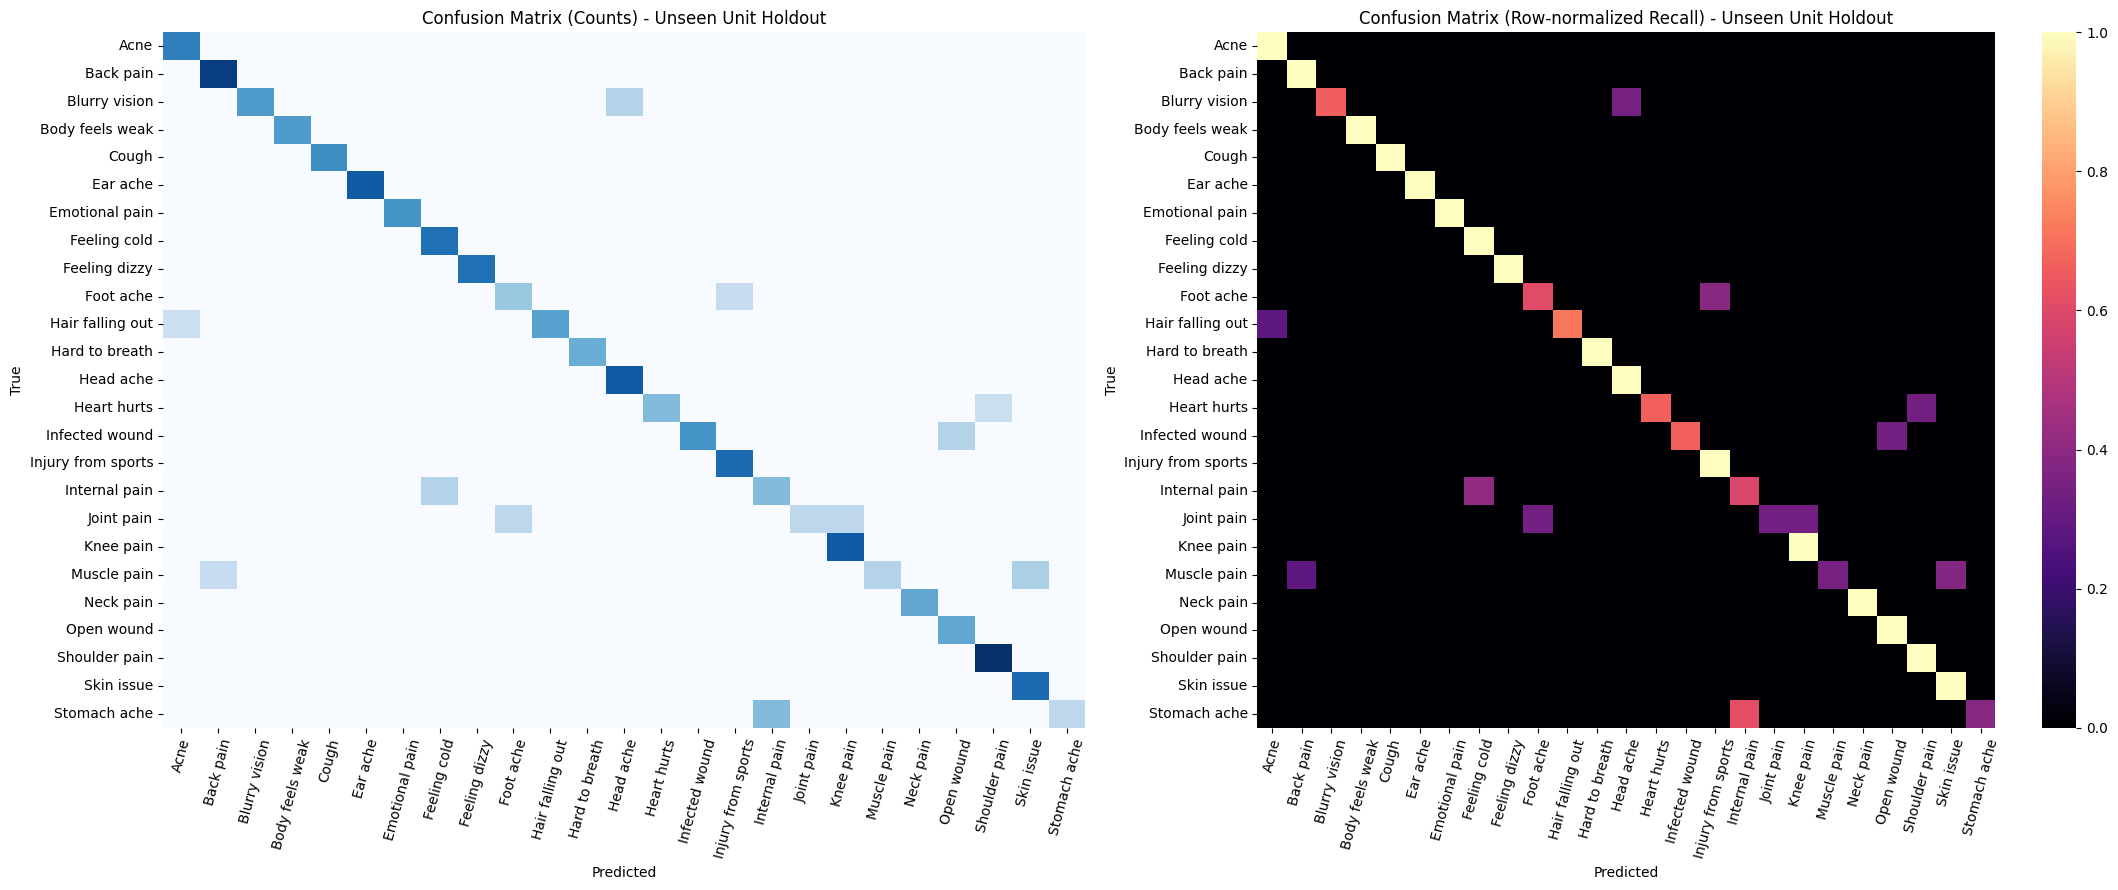

In [227]:
# Confusion matrix (counts and normalized)
cm_counts = confusion_matrix(y_true_u, y_pred_u)
cm_norm = confusion_matrix(y_true_u, y_pred_u, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

sns.heatmap(
    cm_counts,
    ax=axes[0],
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names,
)
axes[0].set_title('Confusion Matrix (Counts) - Unseen Unit Holdout')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].tick_params(axis='x', rotation=75)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(
    cm_norm,
    ax=axes[1],
    cmap='magma',
    cbar=True,
    vmin=0,
    vmax=1,
    xticklabels=label_names,
    yticklabels=label_names,
)
axes[1].set_title('Confusion Matrix (Row-normalized Recall) - Unseen Unit Holdout')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].tick_params(axis='x', rotation=75)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()


/var/folders/w6/vv9tmcm5099738crhgdb87cm0000gn/T/ipykernel_43776/1338392853.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vals, y=pairs, palette='viridis')


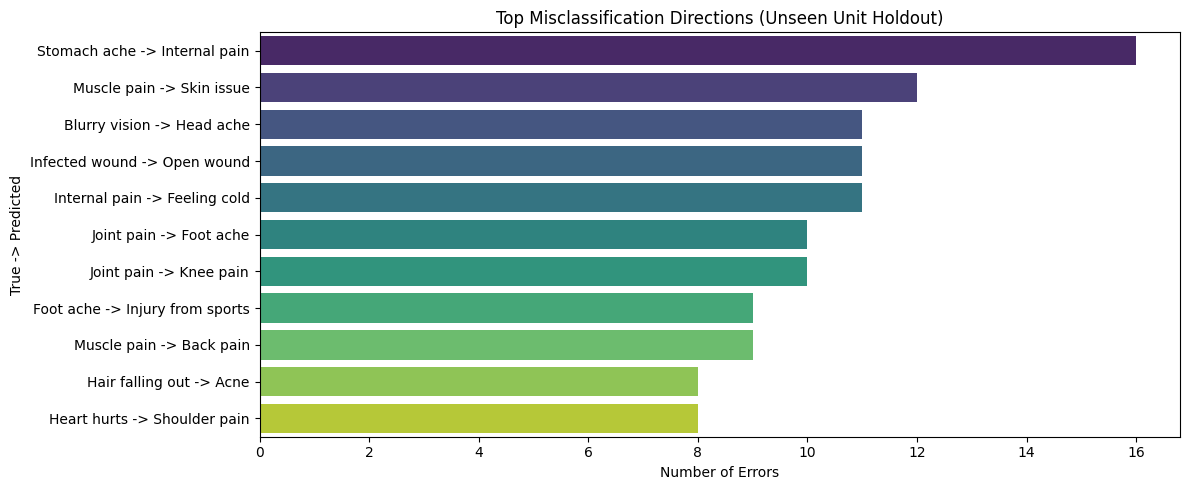

Top confusion pairs:
  Stomach ache -> Internal pain: 16
  Muscle pain -> Skin issue: 12
  Blurry vision -> Head ache: 11
  Infected wound -> Open wound: 11
  Internal pain -> Feeling cold: 11
  Joint pain -> Foot ache: 10
  Joint pain -> Knee pain: 10
  Foot ache -> Injury from sports: 9
  Muscle pain -> Back pain: 9
  Hair falling out -> Acne: 8
  Heart hurts -> Shoulder pain: 8


In [228]:
# Top confusion pairs (off-diagonal)
cm_off = cm_counts.copy()
np.fill_diagonal(cm_off, 0)

confusions = []
for i in range(cm_off.shape[0]):
    for j in range(cm_off.shape[1]):
        if cm_off[i, j] > 0:
            confusions.append((label_names[i], label_names[j], int(cm_off[i, j])))

confusions_sorted = sorted(confusions, key=lambda x: x[2], reverse=True)

if confusions_sorted:
    top_k = min(12, len(confusions_sorted))
    top_conf = confusions_sorted[:top_k]
    pairs = [f"{a} -> {b}" for a, b, _ in top_conf]
    vals = [v for _, _, v in top_conf]

    plt.figure(figsize=(12, 5))
    sns.barplot(x=vals, y=pairs, palette='viridis')
    plt.title('Top Misclassification Directions (Unseen Unit Holdout)')
    plt.xlabel('Number of Errors')
    plt.ylabel('True -> Predicted')
    plt.tight_layout()
    plt.show()

    print('Top confusion pairs:')
    for a, b, v in top_conf:
        print(f"  {a} -> {b}: {v}")
else:
    print('No off-diagonal confusion found.')


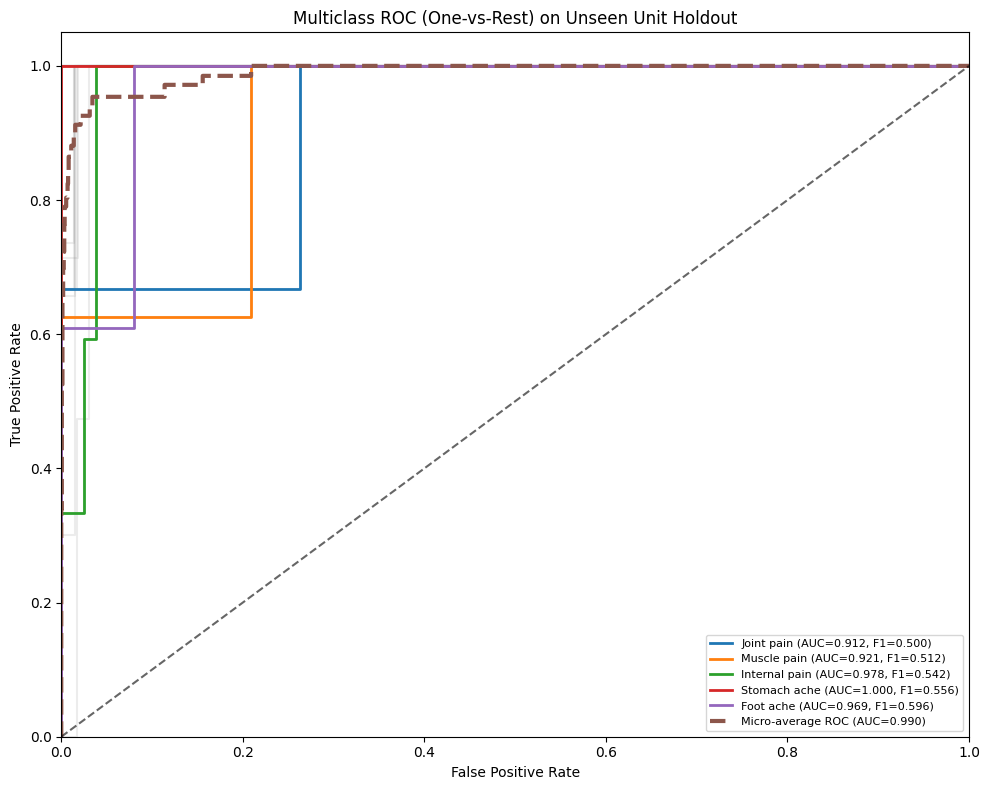

In [232]:
# ROC curves (One-vs-Rest multiclass)
n_classes = len(label_names)
y_true_bin = label_binarize(y_true_u, classes=np.arange(n_classes))

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_prob_u.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Per-class ROC AUC
aoc = {}
fpr = {}
tpr = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_u[:, i])
    aoc[i] = auc(fpr[i], tpr[i])

# Plot all class curves lightly + highlight weakest 5 classes by F1
f1_per_class = f1_score(y_true_u, y_pred_u, average=None, labels=np.arange(n_classes), zero_division=0)
weakest_idx = np.argsort(f1_per_class)[:5]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color='gray', alpha=0.15)

for i in weakest_idx:
    plt.plot(fpr[i], tpr[i], linewidth=2, label=f"{label_names[i]} (AUC={aoc[i]:.3f}, F1={f1_per_class[i]:.3f})")

plt.plot(fpr_micro, tpr_micro, linestyle='--', linewidth=3, label=f"Micro-average ROC (AUC={roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC (One-vs-Rest) on Unseen Unit Holdout')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


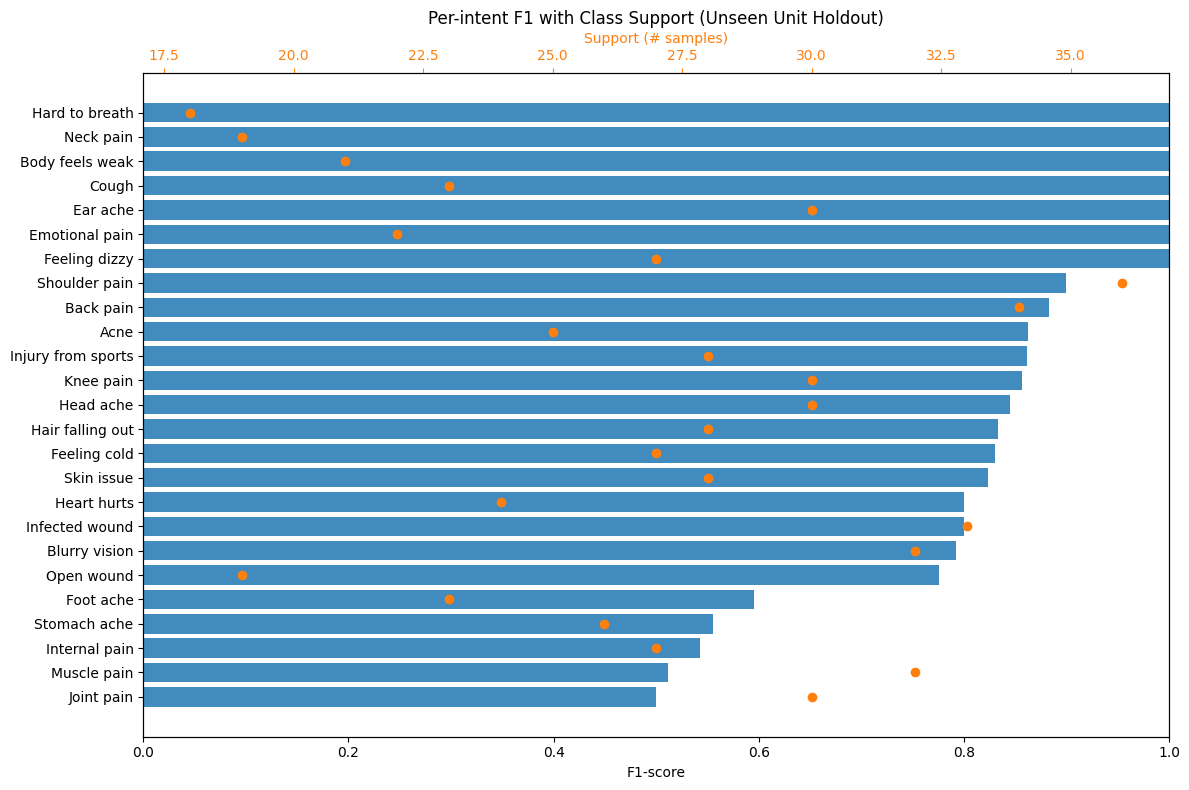

In [234]:
# Class support vs F1
supports = np.bincount(y_true_u, minlength=len(label_names))
f1_vals = f1_score(y_true_u, y_pred_u, average=None, labels=np.arange(len(label_names)), zero_division=0)

class_df = pd.DataFrame({
    'intent': label_names,
    'support': supports,
    'f1': f1_vals,
}).sort_values('f1', ascending=True)

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twiny()

ax1.barh(class_df['intent'], class_df['f1'], color='#1f77b4', alpha=0.85)
ax1.set_xlabel('F1-score')
ax1.set_xlim(0, 1)
ax1.set_title('Per-intent F1 with Class Support (Unseen Unit Holdout)')

ax2.plot(class_df['support'], class_df['intent'], 'o', color='#ff7f0e')
ax2.set_xlabel('Support (# samples)', color='#ff7f0e')
ax2.tick_params(axis='x', colors='#ff7f0e')

plt.tight_layout()
plt.show()


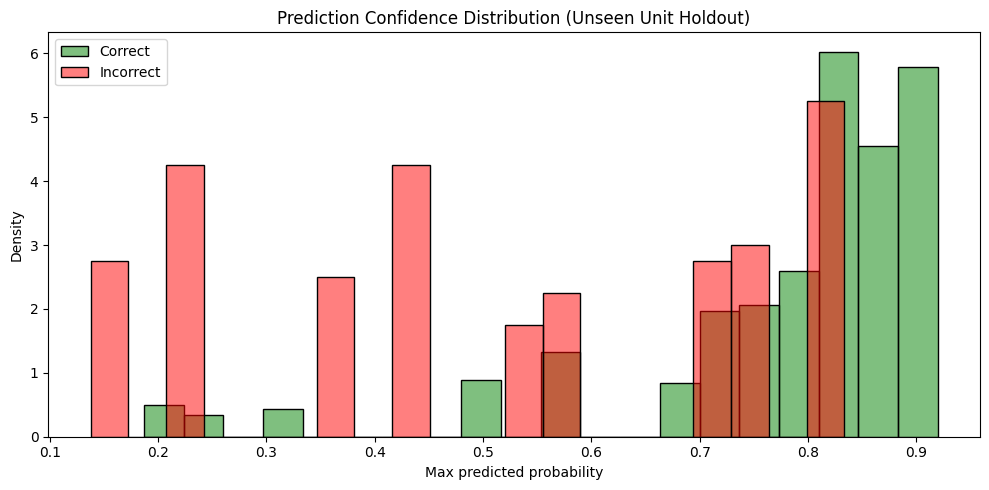

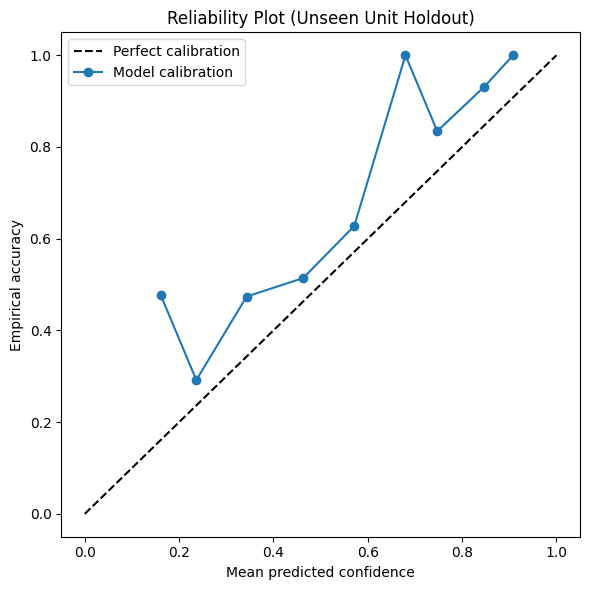

In [236]:
# Confidence diagnostics: correct vs incorrect + reliability by confidence bins
conf = y_prob_u.max(axis=1)
correct = (y_pred_u == y_true_u)

plt.figure(figsize=(10, 5))
sns.histplot(conf[correct], color='green', label='Correct', bins=20, stat='density', alpha=0.5)
sns.histplot(conf[~correct], color='red', label='Incorrect', bins=20, stat='density', alpha=0.5)
plt.title('Prediction Confidence Distribution (Unseen Unit Holdout)')
plt.xlabel('Max predicted probability')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

bins = np.linspace(0, 1, 11)
bin_ids = np.digitize(conf, bins) - 1

bin_centers = []
bin_acc = []
bin_conf = []

for b in range(10):
    idx = bin_ids == b
    if idx.sum() == 0:
        continue
    bin_centers.append((bins[b] + bins[b+1]) / 2)
    bin_acc.append(correct[idx].mean())
    bin_conf.append(conf[idx].mean())

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.plot(bin_conf, bin_acc, marker='o', label='Model calibration')
plt.xlabel('Mean predicted confidence')
plt.ylabel('Empirical accuracy')
plt.title('Reliability Plot (Unseen Unit Holdout)')
plt.legend()
plt.tight_layout()
plt.show()


In [238]:
# Auto-generated insight summary
report_u = classification_report(
    y_true_u,
    y_pred_u,
    target_names=label_names,
    output_dict=True,
    zero_division=0,
)

macro_f1 = report_u['macro avg']['f1-score']
weighted_f1 = report_u['weighted avg']['f1-score']
acc = report_u['accuracy']

per_class_rows = []
for idx, name in enumerate(label_names):
    row = report_u[name]
    per_class_rows.append((name, row['f1-score'], int(supports[idx])))

worst = sorted(per_class_rows, key=lambda x: x[1])[:5]
best = sorted(per_class_rows, key=lambda x: x[1], reverse=True)[:5]

print('Project insight summary (Unseen Unit Holdout):')
print(f"  Accuracy: {acc:.4f}")
print(f"  Macro-F1: {macro_f1:.4f}")
print(f"  Weighted-F1: {weighted_f1:.4f}")

print('\n  Strongest intents by F1:')
for name, f1v, sup in best:
    print(f"    {name}: F1={f1v:.3f}, support={sup}")

print('\n  Weakest intents by F1:')
for name, f1v, sup in worst:
    print(f"    {name}: F1={f1v:.3f}, support={sup}")

if 'confusions_sorted' in globals() and confusions_sorted:
    print('\n  Most frequent confusion directions:')
    for a, b, v in confusions_sorted[:5]:
        print(f"    {a} -> {b}: {v}")

print('\nInterpretation guide:')
print('  1. If a class has low F1 but decent support, it is semantically overlapping with another intent.')
print('  2. If confidence on wrong samples is high, calibration or threshold-based fallback is needed.')
print('  3. Top confusion pairs suggest where to merge intents or add disambiguating training examples.')


Project insight summary (Unseen Unit Holdout):
  Accuracy: 0.8289
  Macro-F1: 0.8228
  Weighted-F1: 0.8152

  Strongest intents by F1:
    Body feels weak: F1=1.000, support=21
    Cough: F1=1.000, support=23
    Ear ache: F1=1.000, support=30
    Emotional pain: F1=1.000, support=22
    Feeling dizzy: F1=1.000, support=27

  Weakest intents by F1:
    Joint pain: F1=0.500, support=30
    Muscle pain: F1=0.512, support=32
    Internal pain: F1=0.542, support=27
    Stomach ache: F1=0.556, support=26
    Foot ache: F1=0.596, support=23

  Most frequent confusion directions:
    Stomach ache -> Internal pain: 16
    Muscle pain -> Skin issue: 12
    Blurry vision -> Head ache: 11
    Infected wound -> Open wound: 11
    Internal pain -> Feeling cold: 11

Interpretation guide:
  1. If a class has low F1 but decent support, it is semantically overlapping with another intent.
  2. If confidence on wrong samples is high, calibration or threshold-based fallback is needed.
  3. Top confusion p

In [241]:
import os, json

output_dir = "/Users/danicasimic/Documents/master projekat/model_artifacts/intent_bert"
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

with open(f"{output_dir}/labels.json", "w") as f:
    json.dump(list(LE.classes_), f)


In [243]:
# Run this in your training notebook after training:
output_dir = "model_artifacts/intent_bert"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

import json
with open(f"{output_dir}/labels.json", "w") as f:
    json.dump(list(LE.classes_), f)